# Add alpha factors

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [461]:
import warnings
warnings.filterwarnings('ignore')

In [462]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [463]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load MERVAL OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

Set data store location:

In [464]:
DATA_STORE = './data/assets.h5'

In [465]:
YEAR = 12

In [466]:
START = 2010
END = 2024

In [467]:
with pd.HDFStore(DATA_STORE, 'r') as store:
    prices = (store['merval/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['merval/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [468]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 180246 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    180246 non-null  float64
 1   high    180246 non-null  float64
 2   low     180246 non-null  float64
 3   close   180246 non-null  float64
 4   volume  180246 non-null  float64
 5   sector  180246 non-null  object 
dtypes: float64(5), object(1)
memory usage: 8.9+ MB


In [469]:
len(prices.index.unique('ticker'))

56

## Remove stocks with less than ten years of data

In [470]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [471]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169923 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    169923 non-null  float64
 1   high    169923 non-null  float64
 2   low     169923 non-null  float64
 3   close   169923 non-null  float64
 4   volume  169923 non-null  float64
 5   sector  169923 non-null  object 
dtypes: float64(5), object(1)
memory usage: 8.4+ MB


In [472]:
len(prices.index.unique('ticker'))

50

## Add some Basic Factors

### Compute the Relative Strength Index

In [473]:
rsi = prices.groupby(level='ticker').close.apply(RSI)
prices['rsi'] = rsi.values

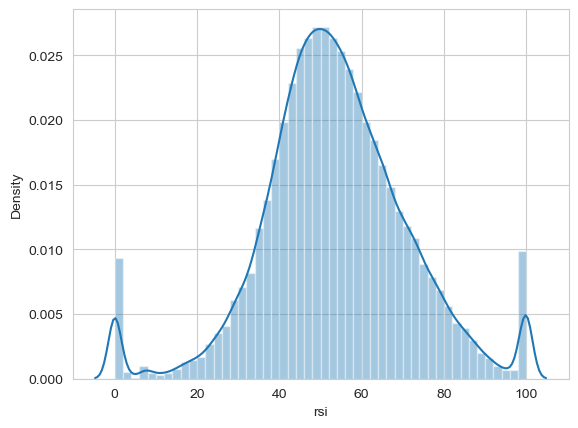

In [474]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [475]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [476]:
bb = prices.groupby(level='ticker').close.apply(compute_bb)

prices['bb_high'] = bb['bb_high'].values
prices['bb_mid'] = bb['bb_mid'].values
prices['bb_low'] = bb['bb_low'].values


In [477]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169923 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   open     169923 non-null  float64
 1   high     169923 non-null  float64
 2   low      169923 non-null  float64
 3   close    169923 non-null  float64
 4   volume   169923 non-null  float64
 5   sector   169923 non-null  object 
 6   rsi      169223 non-null  float64
 7   bb_high  168973 non-null  float64
 8   bb_mid   168973 non-null  float64
 9   bb_low   168973 non-null  float64
dtypes: float64(9), object(1)
memory usage: 13.6+ MB


In [478]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,168973.000000,168973.000000,168973.000000
mean,2.704298,2.622648,2.540999
std,1.705764,1.677142,1.651186
min,0.045079,0.043175,-0.340238
25%,1.266105,1.217069,1.155086
50%,2.455516,2.362196,2.276887
75%,3.821023,3.716403,3.623506
max,10.016267,9.712113,9.587675


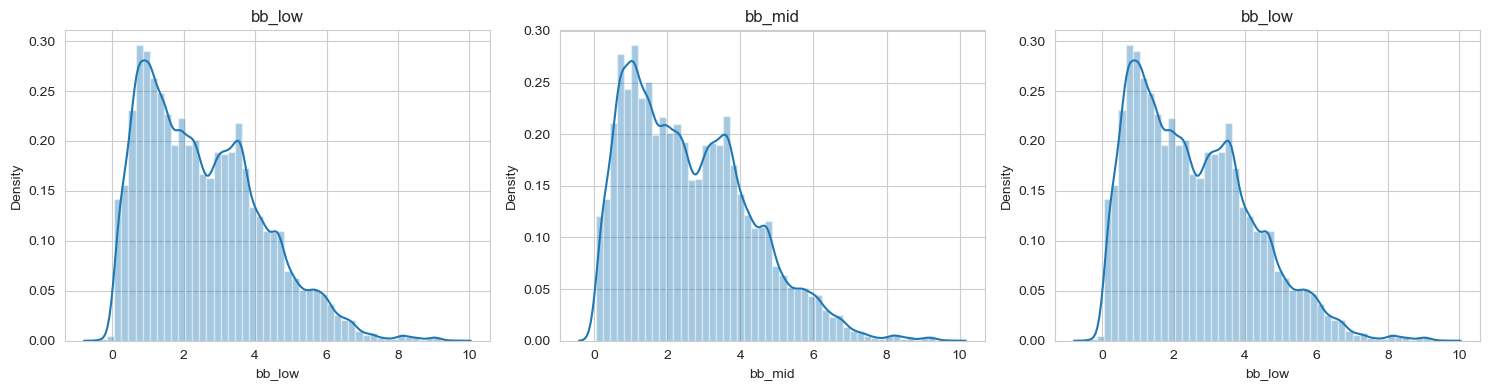

In [479]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [480]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

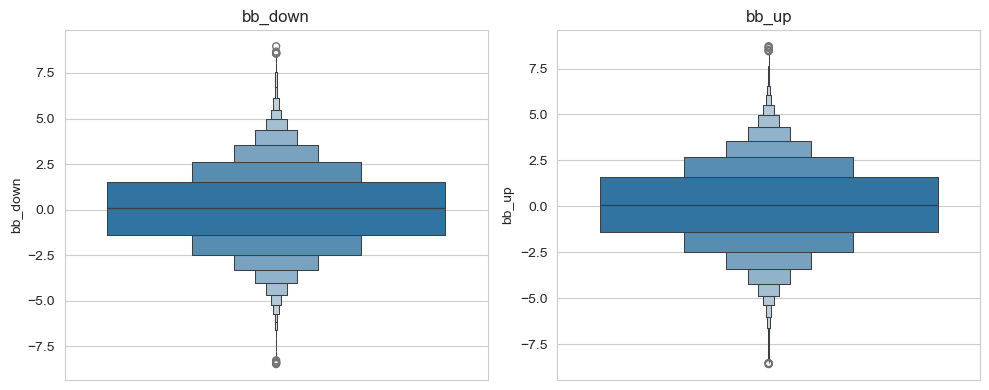

In [481]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [482]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [483]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [484]:
prices['atr'] = by_ticker.apply(compute_atr)

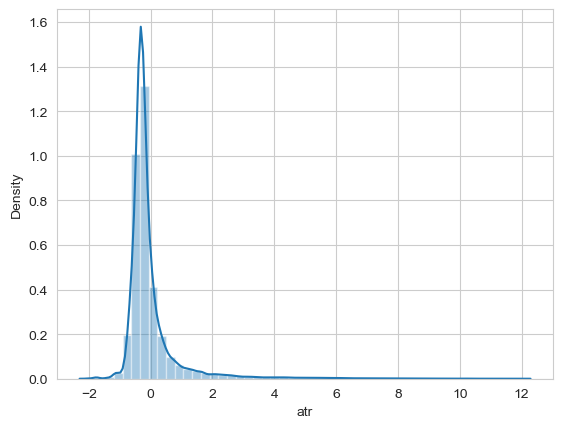

In [485]:
sns.distplot(prices.atr);

In [486]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

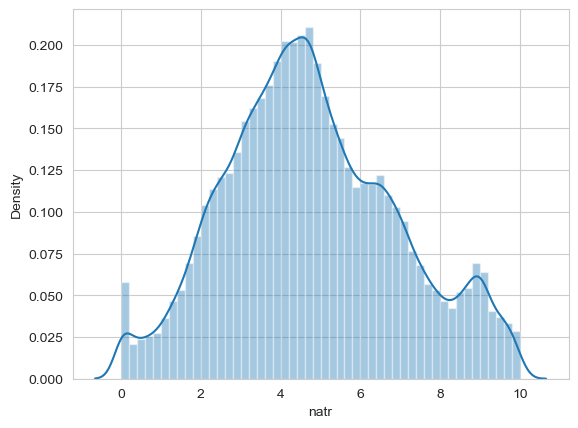

In [487]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [488]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd).values

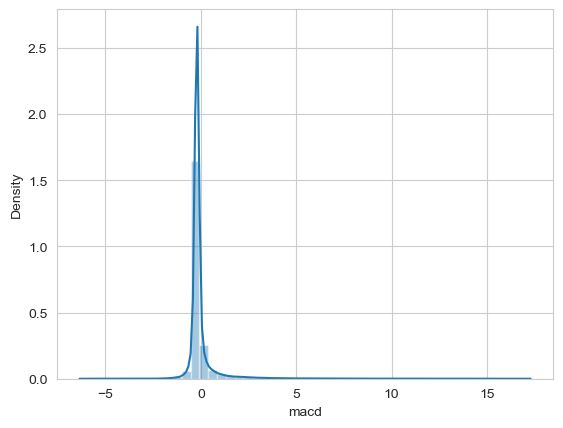

In [489]:
sns.distplot(prices.macd);

## Compute money volume to determine universe

In [490]:
prices['money_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.money_volume /= 1e6

In [491]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [492]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 169923 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   open          169923 non-null  float64
 1   high          169923 non-null  float64
 2   low           169923 non-null  float64
 3   close         169923 non-null  float64
 4   volume        169923 non-null  float64
 5   sector        169923 non-null  object 
 6   rsi           169223 non-null  float64
 7   bb_high       168973 non-null  float64
 8   bb_mid        168973 non-null  float64
 9   bb_low        168973 non-null  float64
 10  bb_up         168973 non-null  float64
 11  bb_down       168973 non-null  float64
 12  atr           169223 non-null  float64
 13  natr          169223 non-null  float64
 14  macd          168273 non-null  float64
 15  money_volume  169923 non-null  float64
dtypes: float6

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [493]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['money_volume', 'volume',
                                                              'open', 'high', 'low']]

In [494]:
prices = prices.unstack('ticker')

In [495]:
data = (pd.concat([prices.money_volume.resample('M').mean().stack('ticker').to_frame('money_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [496]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8361 entries, ('ALUA.BA', Timestamp('2010-01-31 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  8361 non-null   float64
 1   atr           8361 non-null   float64
 2   bb_down       8361 non-null   float64
 3   bb_high       8361 non-null   float64
 4   bb_low        8361 non-null   float64
 5   bb_mid        8361 non-null   float64
 6   bb_up         8361 non-null   float64
 7   close         8361 non-null   float64
 8   macd          8361 non-null   float64
 9   natr          8361 non-null   float64
 10  rsi           8361 non-null   float64
 11  sector        8361 non-null   object 
dtypes: float64(11), object(1)
memory usage: 816.3+ KB


## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [497]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [498]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8311 entries, ('ALUA.BA', Timestamp('2010-02-28 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   8311 non-null   float64
 1   return_3m   8211 non-null   float64
 2   return_6m   8061 non-null   float64
 3   return_12m  7761 non-null   float64
dtypes: float64(4)
memory usage: 287.9+ KB


In [499]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,8311.000000,8211.000000,8061.000000,7761.000000
mean,0.047157,0.038461,0.035914,0.033034
std,0.158293,0.089033,0.062787,0.047806
min,-0.282536,-0.155423,-0.099001,-0.070501
25%,-0.048976,-0.019308,-0.006240,0.000000
50%,0.014271,0.023264,0.027672,0.029662
75%,0.116667,0.087104,0.074249,0.062823
max,0.631870,0.327617,0.219865,0.168808


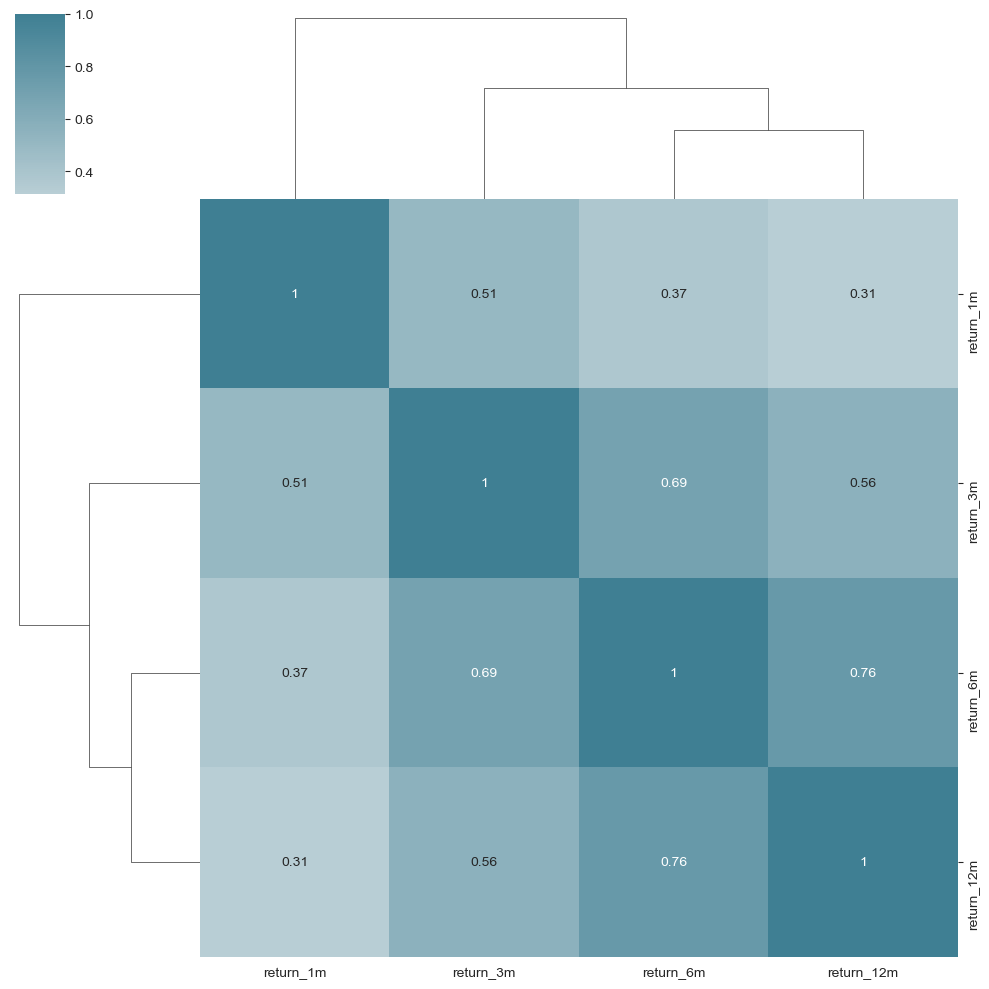

In [500]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [501]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7761 entries, ('ALUA.BA', Timestamp('2011-01-31 00:00:00')) to ('INVJ.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  7761 non-null   float64
 1   atr           7761 non-null   float64
 2   bb_down       7761 non-null   float64
 3   bb_high       7761 non-null   float64
 4   bb_low        7761 non-null   float64
 5   bb_mid        7761 non-null   float64
 6   bb_up         7761 non-null   float64
 7   macd          7761 non-null   float64
 8   natr          7761 non-null   float64
 9   rsi           7761 non-null   float64
 10  sector        7761 non-null   object 
 11  return_1m     7761 non-null   float64
 12  return_3m     7761 non-null   float64
 13  return_6m     7761 non-null   float64
 14  return_12m    7761 non-null   float64
dtypes: float64(14), object(1)
memory usage: 940.2+ KB


In [502]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [503]:
tickers_left = len(data.index.unique('ticker'))
f"the result is {tickers_left} tickers"

'the result is 50 tickers'

## Rolling Factor Betas

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

We can use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [504]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172 entries, 2010-01-31 to 2024-04-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  172 non-null    float64
 1   SMB     172 non-null    float64
 2   HML     172 non-null    float64
 3   RMW     172 non-null    float64
 4   CMA     172 non-null    float64
dtypes: float64(5)
memory usage: 8.1 KB


In [505]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7761 entries, ('ALUA.BA', Timestamp('2011-01-31 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     7761 non-null   float64
 1   SMB        7761 non-null   float64
 2   HML        7761 non-null   float64
 3   RMW        7761 non-null   float64
 4   CMA        7761 non-null   float64
 5   return_1m  7761 non-null   float64
dtypes: float64(6)
memory usage: 392.4+ KB


In [506]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000
mean,0.010149,-0.000932,-0.000919,0.003110,0.000245,0.036260
std,0.043464,0.026598,0.033408,0.020216,0.021491,0.154282
min,-0.133900,-0.082800,-0.138700,-0.047500,-0.072200,-0.347136
25%,-0.015500,-0.019300,-0.018300,-0.011700,-0.013600,-0.059998
50%,0.012700,-0.000600,-0.003700,0.003000,-0.000800,0.007609
75%,0.034000,0.015700,0.013800,0.015600,0.012400,0.104714
max,0.136500,0.073200,0.127500,0.072000,0.077200,0.669570


In [507]:
T = 60
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [508]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,7761.000000
mean,0.052182,-0.386584,0.051824,-0.014564,0.120549,-0.109469
std,0.629834,0.836329,0.855284,1.108469,1.365565,1.493887
min,-2.180037,-3.525452,-2.734880,-3.700288,-4.495103,-7.412233
25%,-0.321082,-0.893639,-0.485665,-0.733440,-0.789444,-0.631847
50%,0.077933,-0.323710,0.063009,-0.020771,0.135177,0.000000
75%,0.467667,0.141346,0.592178,0.761957,1.036403,0.280320
max,1.896617,3.290422,3.808710,3.587107,4.458973,6.140501


In [509]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,7761.000000
mean,0.052182,-0.386584,0.051824,-0.014564,0.120549,-0.109469
std,0.629834,0.836329,0.855284,1.108469,1.365565,1.493887
min,-2.180037,-3.525452,-2.734880,-3.700288,-4.495103,-7.412233
25%,-0.321082,-0.893639,-0.485665,-0.733440,-0.789444,-0.631847
50%,0.077933,-0.323710,0.063009,-0.020771,0.135177,0.000000
75%,0.467667,0.141346,0.592178,0.761957,1.036403,0.280320
max,1.896617,3.290422,3.808710,3.587107,4.458973,6.140501


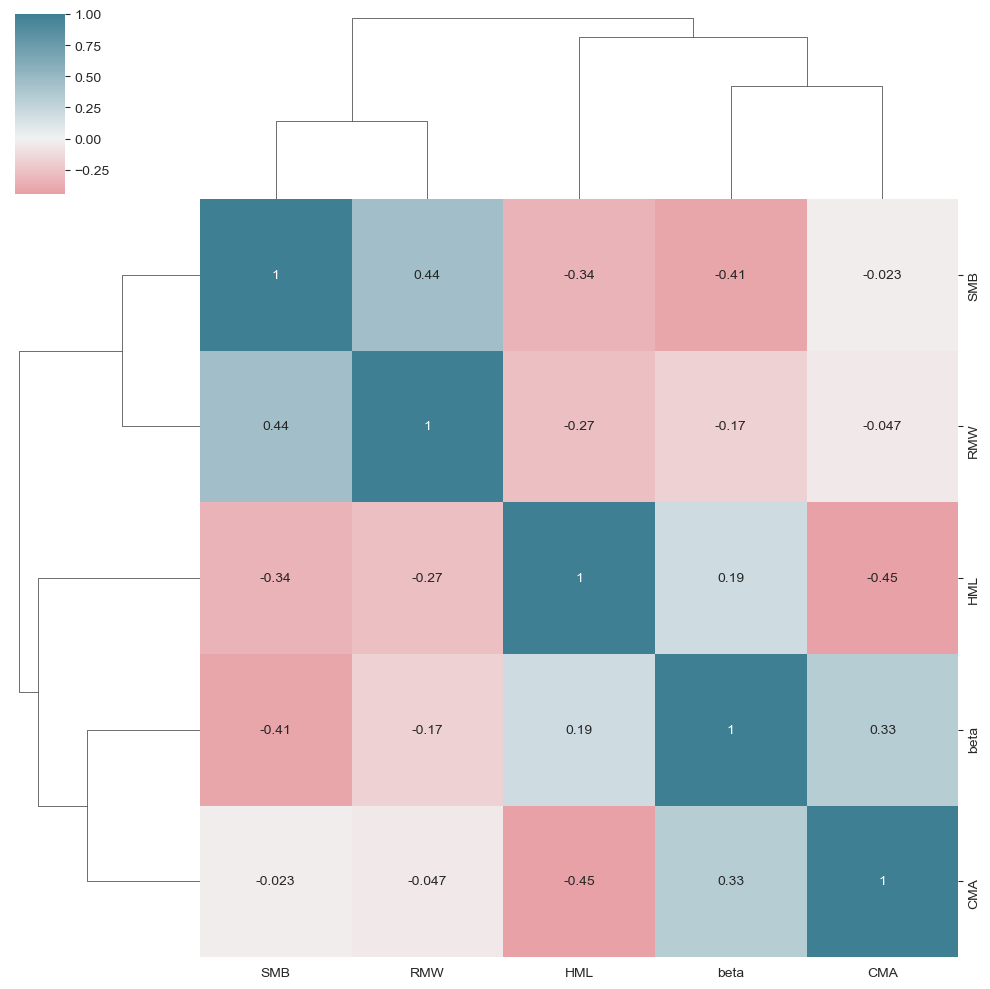

In [510]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [511]:
data = (data
      .join(betas
          .groupby(level='ticker')
          .shift())
     .dropna()
     .sort_index())

In [512]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4761 entries, ('ALUA.BA', Timestamp('2016-01-31 00:00:00')) to ('YPFD.BA', Timestamp('2023-12-31 00:00:00'))
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   money_volume  4761 non-null   float64
 1   atr           4761 non-null   float64
 2   bb_down       4761 non-null   float64
 3   bb_high       4761 non-null   float64
 4   bb_low        4761 non-null   float64
 5   bb_mid        4761 non-null   float64
 6   bb_up         4761 non-null   float64
 7   macd          4761 non-null   float64
 8   natr          4761 non-null   float64
 9   rsi           4761 non-null   float64
 10  sector        4761 non-null   object 
 11  return_1m     4761 non-null   float64
 12  return_3m     4761 non-null   float64
 13  return_6m     4761 non-null   float64
 14  return_12m    4761 non-null   float64
 15  beta          4761 non-null   float64
 16  SMB           4761 non-null  

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [513]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [514]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [515]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [516]:
data = data.dropna()

In [517]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4711 entries, ('ALUA.BA', Timestamp('2016-01-31 00:00:00')) to ('YPFD.BA', Timestamp('2023-11-30 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   money_volume   4711 non-null   float64
 1   atr            4711 non-null   float64
 2   bb_down        4711 non-null   float64
 3   bb_high        4711 non-null   float64
 4   bb_low         4711 non-null   float64
 5   bb_mid         4711 non-null   float64
 6   bb_up          4711 non-null   float64
 7   macd           4711 non-null   float64
 8   natr           4711 non-null   float64
 9   rsi            4711 non-null   float64
 10  sector         4711 non-null   object 
 11  return_1m      4711 non-null   float64
 12  return_3m      4711 non-null   float64
 13  return_6m      4711 non-null   float64
 14  return_12m     4711 non-null   float64
 15  beta           4711 non-null   float64
 16  SMB        

## Sector Breakdown

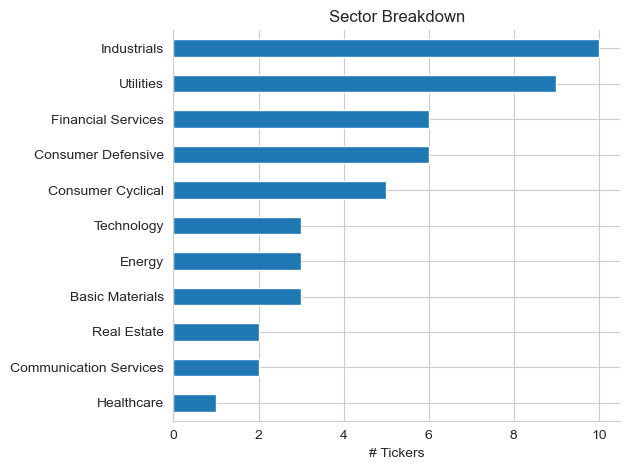

In [518]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [519]:
with pd.HDFStore('data.h5') as store:
    store.put('equities/monthly', data)

## Evaluate mutual information

In [520]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [521]:
mi = mutual_info_regression(X=X, y=data.target)

In [522]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

bb_mid          0.162061
bb_high         0.160878
bb_low          0.150430
return_6m       0.088293
return_12m      0.074462
money_volume    0.066976
year            0.066697
return_1m       0.065723
atr             0.062385
momentum_3      0.060123
dtype: float64

In [523]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [524]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

bb_high         0.110384
bb_mid          0.095549
bb_low          0.093232
rsi             0.039903
month           0.024130
return_12m      0.020475
macd            0.019547
year            0.016636
SMB             0.016127
money_volume    0.013764
dtype: float64

In [525]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [526]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

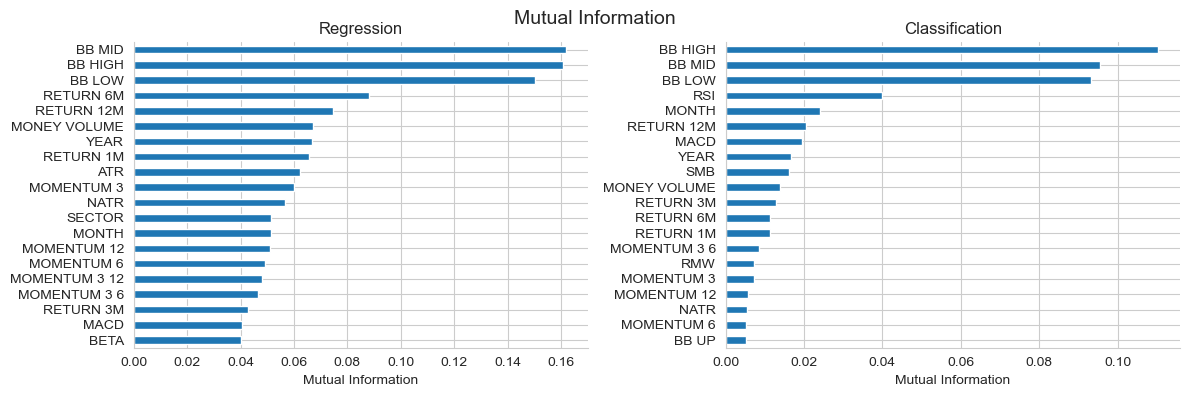

In [527]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)